# Non-Ideal Shock Tube Example
In this example we will illustrate how to setup and use a constant volume, adiabatic reactor to simulate reflected shock tube experiments. This reactor will then be used to compute the ignition delay of a gas at any temperature and pressure.

The example very explicitly follows the form set in `batch_reactor_ignition_delay_NTC.pynb`, which does very similar calculations, but with an `IdealGasReactor`. This example generalizes that work to use a `Reactor` with no pre-assumed EoS. One can also run ideal gas phases through this simulation, simply by specifying an input file with that thermodynamic EoS.

Other than the typical Cantera dependencies, plotting functions require that you have matplotlib installed, and data storing and analysis requires pandas. See https://matplotlib.org/ and https://pandas.pydata.org/index.html, respectively, for additional info.
 
The example here demonstrates the calculations carried out by G. Kogekar, et al., "Impact of non-ideal behavior on ignition delay and chemical kinetics in high-pressure shock tube reactors," Combust. Flame., 2018, https://doi.org/10.1016/j.combustflame.2017.10.014

The reflected shock tube reactor is modeled as a closed, constant-volume, adiabatic reactor. The heat transfer and the work rates are therefore both zero. With no mass inlets or exits, the 1st law energy balance reduces to:

\begin{equation*}
\frac{dU}{dt} = \dot{Q} - \dot{W} = 0.
\end{equation*}
 
Because of the constant-mass and constant-volume assumptions, the density is also therefore constant:

\begin{equation*}
\frac{d\rho}{dt} = 0.
\end{equation*}

Along with the evolving gas composition, the thermodynamic state of the gas is defined by the initial total internal energy $U = mu = m\sum_k\left(Y_k u_k\right)$, where $u_k$ and $Y_k$ are the specific internal energy (kJ/kg) and mass fraction of species $k$, respectively. 

The species mass fractions evolve according to the net chemical production rates due to homogeneous gas-phase reactions:

\begin{equation*}
\frac{dY_k}{dt} = \frac{W_k}{\rho}\dot{\omega}_k,
\end{equation*}

where $W_k$ is the molecular weight of species $k$ $\left({\rm kg}\,{\rm kmol}^{-3}\right)$, $\rho$ is the (constant) gas-phase density $\left({\rm kg}\,{\rm m^{-3}}\right)$, and $\dot{\omega}_k$ is the net production rate of species $k$ $\left({\rm kmol}\,{\rm m^{-3}}\,{\rm s^{-1}}\right)$.

In [11]:
import pandas as pd
import numpy as np

import time

import cantera as ct

print(f"Runnning Cantera version: {ct.__version__}")

Runnning Cantera version: 3.0.0


In [12]:
%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]
import matplotlib.pyplot as plt

plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 120

### Define the gas

In this example we will choose a stoichiometric mixture of n-dodecane and air as the gas. For a representative kinetic model, we use that developed by Wang, Ra, Jia, and Reitz (https://www.erc.wisc.edu/chem_mech/nC12-PAH_mech.zip) by [H.Wang, Y.Ra, M.Jia, R.Reitz, Development of a reduced n-dodecane-PAH mechanism and its application for n-dodecane soot predictions, $Fuel$ 136 (2014) 25–36].

To fun a different model or use a different EoS, simply replace this cti file with a different mechanism file.

In [13]:
gas = ct.Solution("../data/WangMechanismRK.yaml")

### Define reactor conditions : temperature, pressure, fuel, stoichiometry

In [14]:
# Define the reactor temperature and pressure:
reactor_temperature = 1000  # Kelvin
reactor_pressure = 40.0 * 101325.0  # Pascal

# Set the state of the gas object:
gas.TP = reactor_temperature, reactor_pressure

# Define the fuel, oxidizer and set the stoichiometry:
gas.set_equivalence_ratio(phi=1.0, fuel="c12h26", oxidizer={"o2": 1.0, "n2": 3.76})

# Create a reactor object and add it to a reactor network
# In this example, this will be the only reactor in the network
r = ct.Reactor(contents=gas)
reactor_network = ct.ReactorNet([r])
# Create a SolutionArray to store the solution data
time_history = ct.SolutionArray(gas, extra="time")

### Define useful functions

In [15]:
def ignition_delay(df, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    return df[species].idxmax()

In [16]:
# Tic
t0 = time.time()

# This is a starting estimate. If you do not get an ignition within this time, increase it
estimated_ignition_delay_time = 0.005
t = 0

counter = 1
while t < estimated_ignition_delay_time:
    t = reactor_network.step()
    if counter % 20 == 0:
        # We will save only every 20th value. Otherwise, this takes too long
        # Note that the species concentrations are mass fractions
        time_history.append(state=r.thermo.state, time=t)
    counter += 1

# We will use the 'oh' species to compute the ignition delay
# Since 'ignition_delay' operates on a pandas DataFrame, we must
# convert the SolutionArray to a DataFrame and set the 'time'
# column as the DataFrame index
time_history_df = time_history.to_pandas().set_index("time")
tau = ignition_delay(time_history_df, "Y_oh")
# Toc
t1 = time.time()

print(f"Computed Ignition Delay: {tau:.3e} seconds. Took {t1 - t0:3.2f}s to compute")

# If you want to save all the data - molefractions, temperature, pressure, etc
# uncomment the next line
# time_history.to_csv("time_history.csv")

Computed Ignition Delay: 4.093e-04 seconds. Took 3.95s to compute


## Plot the result

### Figure illustrating the definition of ignition delay

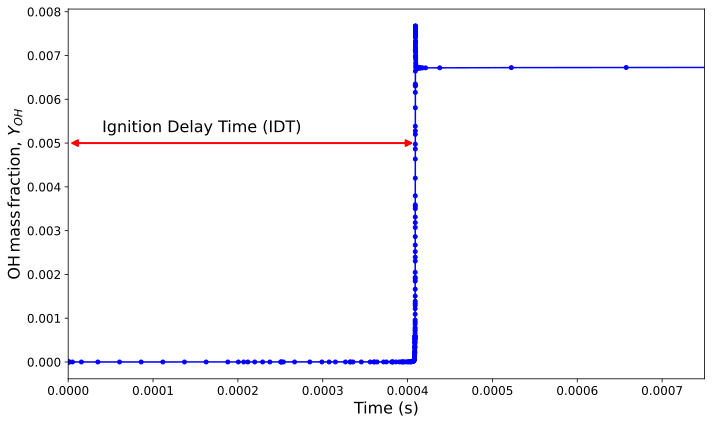

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_history_df.index, time_history_df["Y_oh"], "-o", color="b", markersize=4)
ax.set_xlabel("Time (s)")
ax.set_ylabel("$\mathdefault{OH\, mass\, fraction,}\,  Y_{OH}$")

# Figure formatting:
ax.set_xlim([0, 0.00075])
ax.annotate(
    "",
    xy=(tau, 0.005),
    xytext=(0, 0.005),
    arrowprops=dict(arrowstyle="<|-|>", color="r", linewidth=2.0),
    fontsize=14,
)
ax.annotate(
    "Ignition Delay Time (IDT)",
    xy=(0, 0),
    xytext=(0.00004, 0.00525),
    fontsize=16,
);

## Illustration : NTC behavior
In the paper by Kogekar, et al., the reactor model is used to demonstrate the impacts of non-ideal behavior on IDTs in the **N**egative **T**emperature **C**oefficient region, where observed IDTs, counter to intuition, increase with increasing temperature.

### Define the temperatures for which we will run the simulations

In [18]:
# Make a list of all the temperatures we would like to run simulations at
inverse_T = np.hstack(
    (
        np.linspace(0.6, 0.8, num=3),
        np.linspace(0.9, 1.1, num=9),
        np.linspace(1.15, 1.4, num=6),
    )
)
T = 1000.0 / inverse_T

# Set the initial guesses to a common value.  We could probably speed up simulations
# by tuning this guess, but as seen in the figure above, the 'extra' time after igntion
# does not add many data points or simulation steps. The time savings would be small.
estimated_ignition_delay_times = np.ones_like(T) * 0.005

# Now create a SolutionArray
ignition_delays = ct.SolutionArray(
    gas, shape=T.shape, extra={"tau": estimated_ignition_delay_times}
)
ignition_delays.TP = T, 40.0 * 101325.0
ignition_delays.set_equivalence_ratio(
    phi=1.0, fuel="c12h26", oxidizer={"o2": 1.0, "n2": 3.76}
)

Run the code above for each temperature, and save the IDT for each.

In [35]:
taus = []
for i, state in enumerate(ignition_delays):
    # Set up the gas and reactor
    gas.TPX = state.TPX
    r = ct.Reactor(contents=gas)
    reactor_network = ct.ReactorNet([r])
    time_history = []
    Y_oh_history = []

    t0 = time.time()
    t = 0
    counter = 0

    while t < ignition_delays.tau[i]:
        t = reactor_network.step()
        if not counter % 20:
            time_history.append(t)
            Y_oh_history.append(r.thermo.Y[gas.species_index("oh")])
        counter += 1

    tau = time_history[np.array(Y_oh_history).argmax()]
    t1 = time.time()

    print(
        f"Computed Ignition Delay: {tau:.3e} seconds for T={state.T}K. Took {t1 - t0:3.2f}s to compute"
    )

    taus.append(tau)

ignition_delays.tau = taus

Computed Ignition Delay: 1.126e-06 seconds for T=3404.096840292843K. Took 2.63s to compute
Computed Ignition Delay: 4.657e-06 seconds for T=3304.2304782661195K. Took 2.96s to compute
Computed Ignition Delay: 2.274e-05 seconds for T=3227.003237879922K. Took 3.27s to compute
Computed Ignition Delay: 1.148e-04 seconds for T=3164.365404062119K. Took 3.81s to compute
Computed Ignition Delay: 1.698e-04 seconds for T=3149.8188246866016K. Took 3.62s to compute
Computed Ignition Delay: 2.451e-04 seconds for T=3135.1980391089005K. Took 3.68s to compute
Computed Ignition Delay: 3.344e-04 seconds for T=3120.214201030819K. Took 3.89s to compute
Computed Ignition Delay: 4.093e-04 seconds for T=3104.7780922722122K. Took 3.95s to compute
Computed Ignition Delay: 4.292e-04 seconds for T=3089.216442092766K. Took 3.94s to compute
Computed Ignition Delay: 3.960e-04 seconds for T=3074.2004661671817K. Took 4.09s to compute
Computed Ignition Delay: 3.500e-04 seconds for T=3060.3350028544382K. Took 4.33s to c

### Figure: ignition delay ($\tau$) vs. the inverse of temperature ($\frac{1000}{T}$). 

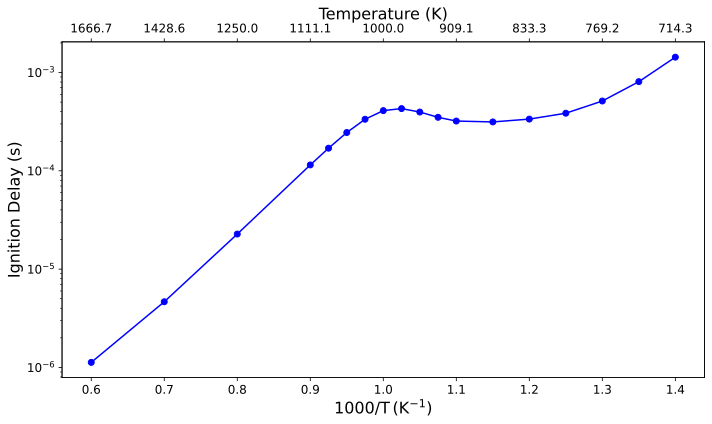

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.semilogy(1000 / ignition_delays.T, ignition_delays.tau, "o-", color="b")
ax.set_ylabel("Ignition Delay (s)", fontsize=16)
ax.set_xlabel(r"$\mathdefault{1000/T\, (K^{-1})}$", fontsize=16)

# Add a second axis on top to plot the temperature for better readability
ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000 / ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel("Temperature (K)", fontsize=16);